# 1. Environment Setup

In [2]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 1.1 Clean Data

In [5]:
data = pd.read_csv('ENSO.csv')

# Remove rows with null values
data.dropna(inplace=True)

# Drop columns: 'date', 'year', 'month', and any season columns mentioned
# Adjust the column names to match those in your dataset
cols_to_drop = ['Date', 'Year', 'Month', 'Season (2-Month)', 'Season (3-Month)', 'Season (12-Month)']
existing_cols_to_drop = [col for col in cols_to_drop if col in data.columns]
data = data.drop(columns=existing_cols_to_drop, errors='ignore')

## 1.2 Encode Data

In [6]:
def encode_enso(value):
    if 'E' in value.upper():
        return 0
    elif 'N' in value.upper():
        return 1
    elif 'L' in value.upper():
        return 2
    else:
        # If there are unexpected values, handle gracefully
        return np.nan

if 'ENSO Phase-Intensity' in data.columns:
    data['ENSO'] = data['ENSO Phase-Intensity'].apply(encode_enso)
    data.drop(columns=['ENSO Phase-Intensity'], inplace=True)

data.head()

,Global Temperature Anomalies,Nino 1+2 SST,Nino 1+2 SST Anomalies,Nino 3 SST,Nino 3 SST Anomalies,Nino 3.4 SST,Nino 3.4 SST Anomalies,Nino 4 SST,Nino 4 SST Anomalies,TNI,PNA,OLR,SOI,MEI.v2,ONI,ENSO
384,0.11,24.28,-0.24,25.84,0.17,26.65,0.08,28.01,-0.21,-1.067,-1.75,0.9,1.2,-0.4,-0.1,0
385,0.21,25.38,-0.72,26.26,-0.11,26.54,-0.20,27.99,-0.11,-1.466,-1.20,0.1,0.3,-0.6,0.1,0
386,0.11,25.22,-1.38,26.92,-0.25,27.09,-0.14,28.18,-0.05,-1.922,-1.66,-0.6,0.6,-0.3,0.2,0
387,0.21,24.57,-1.16,27.52,-0.05,27.83,0.02,28.61,0.10,-2.359,-2.08,0.0,0.1,0.1,0.5,0
388,0.18,24.00,-0.62,27.70,0.49,28.37,0.49,29.19,0.40,-2.364,-0.53,0.4,-0.3,0.7,0.7,0


## 1.3 Standardize Data

In [7]:
# Prepare data
X = data.drop(columns=['ENSO'])
y = data['ENSO']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 1.4 PCA

In [8]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA components
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['ENSO'] = y

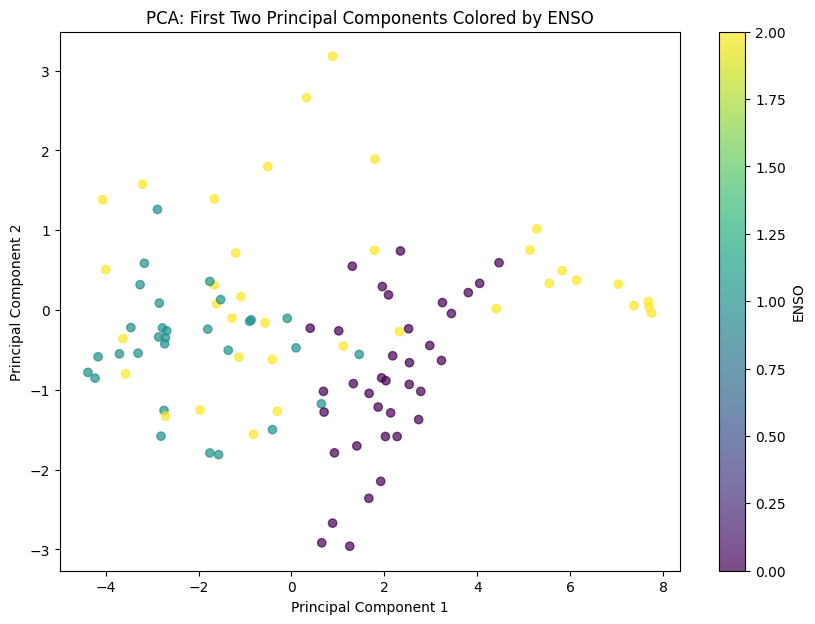

In [9]:
# Plot the first two principal components
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['ENSO'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='ENSO')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components Colored by ENSO')
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

## 2. Base Model (Decision Tree)

A Decision Tree is a good base model because of its simplicity, interpretability, and ability to handle both numerical and categorical data. It is a tree-based model that doesn't apply ensemble techniques, which allows us to see the advantages/disadvantages to bagging/boosting later on.

Decision Tree Performance:
Accuracy: 0.56


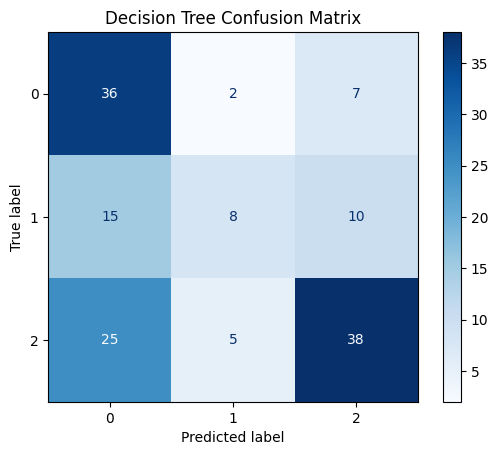

In [11]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluate
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_dt:.2f}")

# Plot Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt_model.classes_)
disp.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

# 3. Bagging (Random Forest)
**Bagging (Bootstrap Aggregation)** is an ensemble method that involves:
1. Creating multiple bootstrapped datasets by sampling the training data with replacement.
2. Training a model (e.g., Decision Tree) on each bootstrapped dataset independently.
3. Combining predictions using majority voting (classification) or averaging (regression).

*When to Use Bagging:*
- When models are prone to high variance (e.g., Decision Trees).
- When you need to reduce overfitting and improve generalization.
- Works best for unstable models, like Decision Trees, where small changes in input data can significantly impact results.

Random Forest Performance:
Accuracy: 0.60


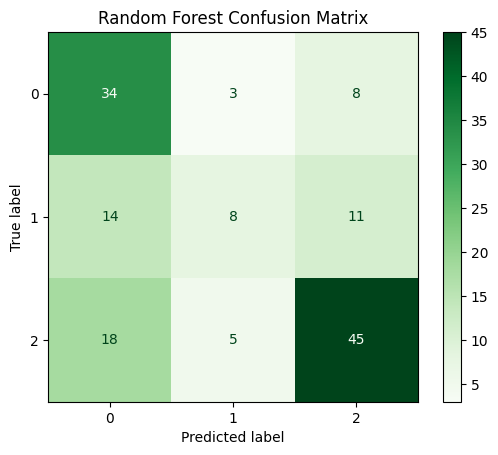

In [12]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_rf:.2f}")

# Plot Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp.plot(cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()

# 4. Boosting (Gradient Boosting)
**What is Boosting and Why Use It?**
- Boosting is an iterative ensemble technique that trains models sequentially, with each new model focusing on correcting the errors made by previous models. The weights of misclassified samples are increased so that subsequent models pay more attention to these errors.

*Why Use Boosting:*
- Boosting reduces both bias and variance.
- It is well-suited for complex relationships in data and often achieves higher accuracy.
- Popular boosting algorithms include Gradient Boosting, AdaBoost, and XGBoost.
- However, Boosting can be sensitive to noisy data and may overfit if not properly regularized

Gradient Boosting Performance:
Accuracy: 0.55


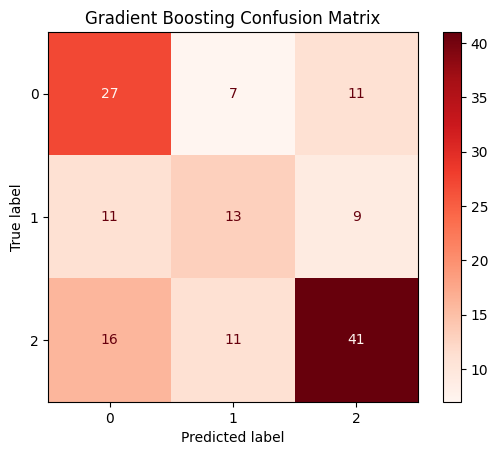

In [13]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predict
y_pred_gb = gb_model.predict(X_test)

# Evaluate
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Performance:")
print(f"Accuracy: {accuracy_gb:.2f}")

# Plot Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=gb_model.classes_)
disp.plot(cmap='Reds')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# 5. Comparisons

Model Performance Summary:
Decision Tree Accuracy: 0.56
Random Forest Accuracy: 0.60
Gradient Boosting Accuracy: 0.55


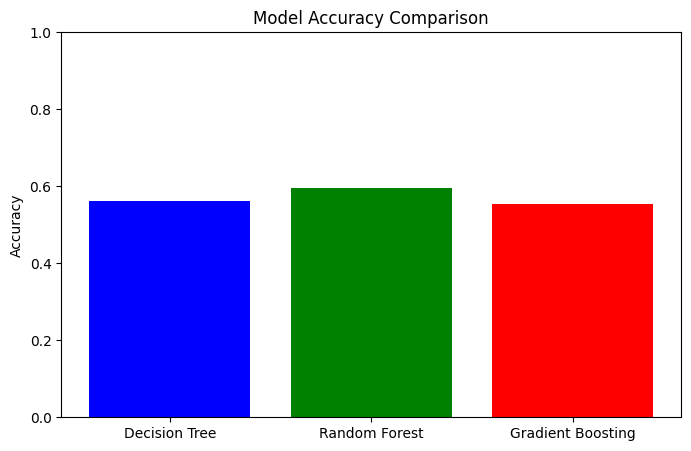

In [14]:
# Summary of Results
print("Model Performance Summary:")
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")

# Visualize Results
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
accuracies = [accuracy_dt, accuracy_rf, accuracy_gb]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# 6. Optimization

/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_81138/4074467606.py:26: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = cv_results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_81138/4074467606.py:26: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = cv_results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')


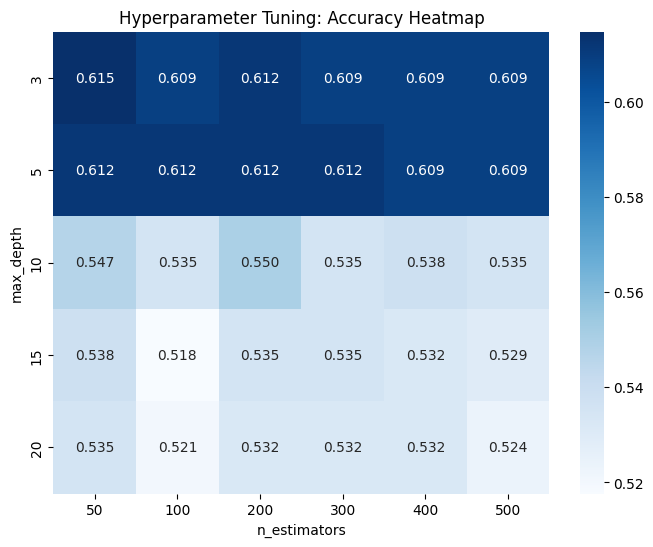

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [3, 5, 10, 15, 20]
}

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Create pivot table for heatmap
pivot_table = cv_results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="Blues", fmt=".3f")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("Hyperparameter Tuning: Accuracy Heatmap")
plt.show()
